In [89]:
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset
import numpy as np
from datasets import Dataset
import pandas as pd
import re
import matplotlib.pyplot as plt

from prettytable import PrettyTable
from sklearn.metrics.pairwise import cosine_similarity
import random
import faiss

In [90]:
model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')

In [4]:
# Load the dataset
# dataset = load_dataset("sentence-transformers/squad")

# # Load the bi-encoder model
# model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')

# # Extract the questions and answers
# questions = dataset['train']['question']
# answers = dataset['train']['answer']


# # Compute embeddings for questions and answers
# question_embeddings = model.encode(questions, convert_to_tensor=True, show_progress_bar=True)
# answer_embeddings = model.encode(answers, convert_to_tensor=True, show_progress_bar=True)

# # Save embeddings for further analysis
# question_embeddings_np = question_embeddings.cpu().numpy()
# answer_embeddings_np = answer_embeddings.cpu().numpy()

# # Prepare a DataFrame for better data handling
# data = pd.DataFrame({'question': questions, 'answer': answers})
# data['question_embedding'] = list(question_embeddings_np)
# data['answer_embedding'] = list(answer_embeddings_np)

# data.head()


# data['question_embedding'] = data['question_embedding'].apply(lambda x: ','.join(map(str, x)))
# data['answer_embedding'] = data['answer_embedding'].apply(lambda x: ','.join(map(str, x)))


# data.to_csv('embeddings_zad3.csv', index=False)

In [91]:
data = pd.read_csv('embeddings_zad3.csv')
questions = data['question'].to_list()
answers = data['answer'].to_list()

In [92]:
len(questions)

87599

In [93]:
len(answers)

87599

In [94]:
# data.to_csv('embeddings_zad3.csv')

In [95]:
len(data)

87599

In [96]:
data.head()

,question,answer,question_embedding,answer_embedding
0,To whom did the Virgin Mary allegedly appear i...,"Architecturally, the school has a Catholic cha...","0.06718871,-0.12966466,-0.37205586,0.006261317...","0.09202517,-0.115098976,-0.09249751,0.5962876,..."
1,What is in front of the Notre Dame Main Building?,"Architecturally, the school has a Catholic cha...","-0.07572576,-0.03680766,-0.44445643,0.16445722...","0.092025176,-0.1150988,-0.09249752,0.5962877,-..."
2,The Basilica of the Sacred heart at Notre Dame...,"Architecturally, the school has a Catholic cha...","-0.1723356,0.036861535,-0.42555916,0.29381517,...","0.092025176,-0.1150988,-0.09249752,0.5962877,-..."
3,What is the Grotto at Notre Dame?,"Architecturally, the school has a Catholic cha...","-0.030828943,-0.05760375,-0.40976864,0.1731917...","0.092025176,-0.1150988,-0.09249752,0.5962877,-..."
4,What sits on top of the Main Building at Notre...,"Architecturally, the school has a Catholic cha...","-0.026436264,-0.012920242,-0.4135109,0.2183376...","0.092025176,-0.1150988,-0.09249752,0.5962877,-..."


In [97]:
len(data['question'])

87599

In [98]:
len(data['question'].unique())

87341

# Przygotowanie danych

In [99]:


def fix_and_convert_to_array(embedding_str):
   
    fixed_str = re.sub(r'(\d)(\s)(-?\d)', r'\1,\3', embedding_str.strip())
    fixed_str = fixed_str.replace('[', '').replace(']', '')  
    fixed_list = list(map(float, fixed_str.split(',')))  
    return np.array(fixed_list) 


data['question_embedding'] = data['question_embedding'].apply(fix_and_convert_to_array)
data['answer_embedding'] = data['answer_embedding'].apply(fix_and_convert_to_array)
 
question_embeddings_np = np.vstack(data['question_embedding'].to_numpy())
answer_embeddings_np = np.vstack(data['answer_embedding'].to_numpy())


# Wyszukiwanie semantyczne

In [100]:


def semantic_search(query, answer_embedding, answer_texts, top_k=5):
    query_embedding = model.encode([query], convert_to_tensor=True)
    cosine_scores = cosine_similarity(
        query_embedding.cpu().numpy(), answer_embedding
    )
    top_k_indices = np.argsort(cosine_scores[0])[-top_k:][::-1]
    return [(cosine_scores[0][i], answer_texts[i]) for i in top_k_indices]


def get_simple_answer_semantic(query, k=20):
    print('-------------------------------------------------')
    print('SEMANTIC')
    print('-------------------------------------------------')
    results = semantic_search(query, answer_embeddings_np, answers, top_k=k)
    for rank, (score, ans) in enumerate(results):
        print(f"Rank {rank+1}: Answer: {ans}, Score: {score:.4f}")



# Index FAISS

In [101]:

hf_dataset = Dataset.from_pandas(data)


hf_dataset = hf_dataset.add_faiss_index(column="answer_embedding")

def faiss_search_with_hf(query, hf_dataset, model, top_k=5):

    query_embedding = model.encode(query, convert_to_tensor=True).cpu().numpy()
    
    scores, examples = hf_dataset.get_nearest_examples(
        index_name="answer_embedding", 
        query=query_embedding,  # Single query embedding
        k=top_k
    )
    
    return list(zip(scores, examples["answer"]))


def faiss_search_manual(query, embeddings, answers, model, top_k=5, nlist=10):


    d = embeddings.shape[1]  # Wymiar osadzeń

    # Tworzenie IndexIVFFlat z quantizerem IndexFlatL2
    quantizer = faiss.IndexFlatL2(d)
    index = faiss.IndexIVFFlat(quantizer, d, nlist)

    # Trening indeksu (wymaga podania danych treningowych)
    index.train(embeddings)  # Klastrowanie osadzeń
    index.add(embeddings)    # Dodanie osadzeń do indeksu

    # Kodowanie zapytania
    query_embedding = model.encode(query, convert_to_tensor=True).cpu().numpy().astype("float32")

    # Wyszukiwanie K-najbliższych sąsiadów
    _, indices = index.search(np.array([query_embedding]), k=top_k)

    # Mapowanie wyników na odpowiedzi
    results = [answers[indices[0][i]] for i in range(len(indices[0]))]

    return results


def get_simple_answer_faiss(query, k=20):
    faiss_results = faiss_search_with_hf(query, hf_dataset, model, top_k=20)

    faiss_results
    print('-------------------------------------------------')
    print('FAISS')
    print('-------------------------------------------------')
    print(f"Query: {query}")
    for rank, (score, answer) in enumerate(faiss_results):
        print(f"Rank {rank+1}: Answer: {answer}, Score: {score:.4f}")

  0%|          | 0/88 [00:00<?, ?it/s]

In [102]:
query = 'What is the Paris?'
get_simple_answer_faiss(query)
get_simple_answer_semantic(query)

-------------------------------------------------
FAISS
-------------------------------------------------
Query: What is the Paris?
Rank 1: Answer: Paris is located in northern central France. By road it is 450 kilometres (280 mi) south-east of London, 287 kilometres (178 mi) south of Calais, 305 kilometres (190 mi) south-west of Brussels, 774 kilometres (481 mi) north of Marseille, 385 kilometres (239 mi) north-east of Nantes, and 135 kilometres (84 mi) south-east of Rouen. Paris is located in the north-bending arc of the river Seine and includes two islands, the Île Saint-Louis and the larger Île de la Cité, which form the oldest part of the city. The river's mouth on the English Channel (La Manche) is about 233 mi (375 km) downstream of the city, established around 7600 BC. The city is spread widely on both banks of the river. Overall, the city is relatively flat, and the lowest point is 35 m (115 ft) above sea level. Paris has several prominent hills, the highest of which is Montma

In [103]:
query = 'What is the Notre Dame?'
get_simple_answer_faiss(query)
get_simple_answer_semantic(query)

-------------------------------------------------
FAISS
-------------------------------------------------
Query: What is the Notre Dame?
Rank 1: Answer: The University of Notre Dame du Lac (or simply Notre Dame /ˌnoʊtərˈdeɪm/ NOH-tər-DAYM) is a Catholic research university located adjacent to South Bend, Indiana, in the United States. In French, Notre Dame du Lac means "Our Lady of the Lake" and refers to the university's patron saint, the Virgin Mary. The main campus covers 1,250 acres in a suburban setting and it contains a number of recognizable landmarks, such as the Golden Dome, the "Word of Life" mural (commonly known as Touchdown Jesus), and the Basilica., Score: 26.2679
Rank 2: Answer: The University of Notre Dame du Lac (or simply Notre Dame /ˌnoʊtərˈdeɪm/ NOH-tər-DAYM) is a Catholic research university located adjacent to South Bend, Indiana, in the United States. In French, Notre Dame du Lac means "Our Lady of the Lake" and refers to the university's patron saint, the Virgin

In [104]:
query = 'Does Beoynce have a husband?'
#query = 'Who is Beyoncé married to?'
get_simple_answer_faiss(query)
get_simple_answer_semantic(query)

#niepoprawne

-------------------------------------------------
FAISS
-------------------------------------------------
Query: Does Beoynce have a husband?
Rank 1: Answer: In Spain, every person officially has two surnames, one of which is the father's first surname and the other is the mother's first surname. The law contemplates the possibility of joining both surnames with the Catalan conjunction i ("and")., Score: 42.3899
Rank 2: Answer: In Spain, every person officially has two surnames, one of which is the father's first surname and the other is the mother's first surname. The law contemplates the possibility of joining both surnames with the Catalan conjunction i ("and")., Score: 42.3899
Rank 3: Answer: In Spain, every person officially has two surnames, one of which is the father's first surname and the other is the mother's first surname. The law contemplates the possibility of joining both surnames with the Catalan conjunction i ("and")., Score: 42.3899
Rank 4: Answer: In Spain, every pers

In [105]:
query = 'How old is the king Mahendra?'
get_simple_answer_faiss(query)
get_simple_answer_semantic(query)

#poprawne

-------------------------------------------------
FAISS
-------------------------------------------------
Query: How old is the king Mahendra?
Rank 1: Answer: The Tribhuvan Museum contains artifacts related to the King Tribhuvan (1906–1955). It has a variety of pieces including his personal belongings, letters and papers, memorabilia related to events he was involved in and a rare collection of photos and paintings of Royal family members. The Mahendra Museum is dedicated to king Mahendra of Nepal (1920–1972). Like the Tribhuvan Museum, it includes his personal belongings such as decorations, stamps, coins and personal notes and manuscripts, but it also has structural reconstructions of his cabinet room and office chamber. The Hanumandhoka Palace, a lavish medieval palace complex in the Durbar, contains three separate museums of historic importance. These museums include the Birendra museum, which contains items related to the second-last monarch, Birendra of Nepal., Score: 37.2989
Ran

# METRYKI

## Ground truths

In [106]:
question_answer_dict = data.drop_duplicates(subset=['question', 'answer']).set_index('question')['answer'].to_dict()
len(question_answer_dict)

87341

In [107]:
duplicated_questions = data[data.duplicated(subset='question', keep=False)]
duplicated_question_answer_dict = duplicated_questions.groupby('question')['answer'].apply(list).to_dict()
len(duplicated_question_answer_dict)

230

In [108]:

duplicated_question_unique_answer = {
    question: answers for question, answers in duplicated_question_answer_dict.items() if len(answers) == len(set(answers))
}

len(duplicated_question_unique_answer)


66

In [109]:
duplicated_question_unique_answer

{'For every 100 females age 18 and over, how many males were there?': ['In the city, 24.6% of the population were under the age of 18, 10.2% from 18 to 24, 26.8% from 25 to 44, 25.8% from 45 to 64, and 12.7% who were 65 years of age or older. The median age was 36.3 years. For every 100 females there were 96.2 males. For every 100 females age 18 and over, there were 94.4 males.',
  'In the city the population was spread out with 25.7% under the age of 18, 8.9% from 18 to 24, 31.0% from 25 to 44, 20.2% from 45 to 64, and 14.2% who were 65 years of age or older. The median age was 35 years. For every 100 females there were 96.1 males. For every 100 females age 18 and over, there were 93.2 males.'],
 'For every 100 females, how many males were there?': ['In the city, 24.6% of the population were under the age of 18, 10.2% from 18 to 24, 26.8% from 25 to 44, 25.8% from 45 to 64, and 12.7% who were 65 years of age or older. The median age was 36.3 years. For every 100 females there were 96.

In [110]:
complete_dict = question_answer_dict | duplicated_question_answer_dict
len(complete_dict)

87341

In [111]:
complete_dict['Who wrote the Divine Comedy?']

["Dante Alighieri's Divine Comedy, written in the early 14th century, merged a medieval world view with classical ideals. Another promoter of the Italian language was Boccaccio with his Decameron. The application of the vernacular did not entail a rejection of Latin, and both Dante and Boccaccio wrote prolifically in Latin as well as Italian, as would Petrarch later (whose Canzoniere also promoted the vernacular and whose contents are considered the first modern lyric poems). Together the three poets established the Tuscan dialect as the norm for the modern Italian language.",
 "Dante Alighieri's Divine Comedy, derived features of and episodes about Bolgia from Arabic works on Islamic eschatology: the Hadith and the Kitab al-Miraj (translated into Latin in 1264 or shortly before as Liber Scale Machometi) concerning the ascension to Heaven of Muhammad, and the spiritual writings of Ibn Arabi. The Moors also had a noticeable influence on the works of George Peele and William Shakespeare.

## Recall

In [112]:
# recall@k function
def calculate_recall(actual, predicted, k):

    if isinstance(actual, str):
        actual = [actual]

    act_set = set(actual)
    pred_set = set(predicted[:k])

    result = round(len(act_set & pred_set) / float(len(act_set)), 2)
    return result

In [113]:
def generate_tables(query, semantic_search, faiss_search, correct_answers):
    def format_table(header, rows):
        table = f"{header[0]:<40} | {header[1]:<20}\n"
        table += "-" * 65 + "\n"
        for row in rows:
            table += f"{row[0]:<40} | {row[1]:<20}\n"
        return table

    # Prepare rows for each table
    semantic_rows = [(query, result) for result in semantic_search]
    faiss_rows = [(query, result) for result in faiss_search]
    correct_rows = [(query, answer) for answer in correct_answers]

    # Generate tables
    semantic_table = format_table(["Query", "Semantic Result"], semantic_rows)
    faiss_table = format_table(["Query", "FAISS Result"], faiss_rows)
    correct_table = format_table(["Query", "Correct Answer"], correct_rows)

    return semantic_table, faiss_table, correct_table

In [114]:
def compare_answers(query, model, top_k=5, answer_embeddings = answer_embeddings_np, answer_texts=answers, hf_dataset= hf_dataset, correct_answers_dict=complete_dict, is_faiss_automatic= True):
    query_embedding = model.encode([query], convert_to_tensor=True)
    cosine_scores = cosine_similarity(query_embedding.cpu().numpy(), answer_embeddings)
    top_k_indices = np.argsort(cosine_scores[0])[-top_k:][::-1]
    
    semantic_search = [answer_texts[i] for i in top_k_indices]

    if is_faiss_automatic:
        scores, examples = hf_dataset.get_nearest_examples(
            index_name="answer_embedding", 
            query=query_embedding.cpu().numpy(),  
            k=top_k
        )
        
        faiss_search = examples['answer']
    else:
        faiss_search = faiss_search_manual(query, answer_embeddings, answer_texts, model, top_k)


    correct_answers = complete_dict[query]

    semantic_table, faiss_table, correct_table = generate_tables(query, semantic_search, faiss_search, correct_answers)
    return semantic_search, faiss_search, correct_answers,   semantic_table, faiss_table, correct_table

def calculate_metric(metric, semantic_search, faiss_search, correct_answers, k):

    if metric == 'recall':
        recall_semantic = calculate_recall( correct_answers, semantic_search, k)

        recall_faiss = calculate_recall(correct_answers, faiss_search, k)

        return [recall_semantic, recall_faiss]
    

In [115]:

def calculate_and_visualize_recall(query, values, model, print_val = True, is_faiss_automatic=True):
    k_values = values
    recall_values_dict = {}

    for k in values:
        semantic_search, faiss_search, correct_answers,  semantic_table, faiss_table, correct_table = compare_answers(query, model, 50, is_faiss_automatic=is_faiss_automatic)
        result = calculate_metric('recall', semantic_search, faiss_search, correct_answers, k )
        recall_values_dict[k] = result

    if(print_val):
        print("Semantic Search Results:")
        print(semantic_table)
        print("\nFAISS Search Results:")
        print(faiss_table)
        print("\nCorrect Answers:")
        print(correct_table)

        semantic_recall = [recall_values_dict[k][0] for k in k_values]
        faiss_recall = [recall_values_dict[k][1] for k in k_values]

        plt.figure(figsize=(10, 6))
        plt.plot(k_values, semantic_recall, marker='o', label='Semantic Search Recall')
        plt.plot(k_values, faiss_recall, marker='s', label='FAISS Recall')

        plt.title('Recall Values for Semantic Search and FAISS')
        plt.xlabel('k-values')
        plt.ylabel('Recall')
        plt.legend()
        plt.grid(True)
        plt.show()

    return recall_values_dict

In [116]:
# query = 'Who wrote the Divine Comedy?'
# k_values = [1,2,3,4,5,6,7,8,9,10,15]

# calculate_and_visualize_recall(query, k_values, model, True)

In [117]:
random.seed(42)
queries = random.sample(list(duplicated_question_unique_answer.keys()), 6)
queries

['What does CD stand for?',
 'How could a white child be considered a member of the Omaha tribe?',
 'What was the per capita income for the city?',
 'What does DRM stand for?',
 'Who wrote the Divine Comedy?',
 'In what year did Chopin become a French citizen?']

Semantic Search Results:
Query                                    | Semantic Result     
-----------------------------------------------------------------
What does CD stand for?                  | Compact Disc (CD) is a digital optical disc data storage format. The format was originally developed to store and play only sound recordings but was later adapted for storage of data (CD-ROM). Several other formats were further derived from these, including write-once audio and data storage (CD-R), rewritable media (CD-RW), Video Compact Disc (VCD), Super Video Compact Disc (SVCD), Photo CD, PictureCD, CD-i, and Enhanced Music CD. Audio CDs and audio CD players have been commercially available since October 1982.
What does CD stand for?                  | Compact Disc (CD) is a digital optical disc data storage format. The format was originally developed to store and play only sound recordings but was later adapted for storage of data (CD-ROM). Several other formats were further derived from

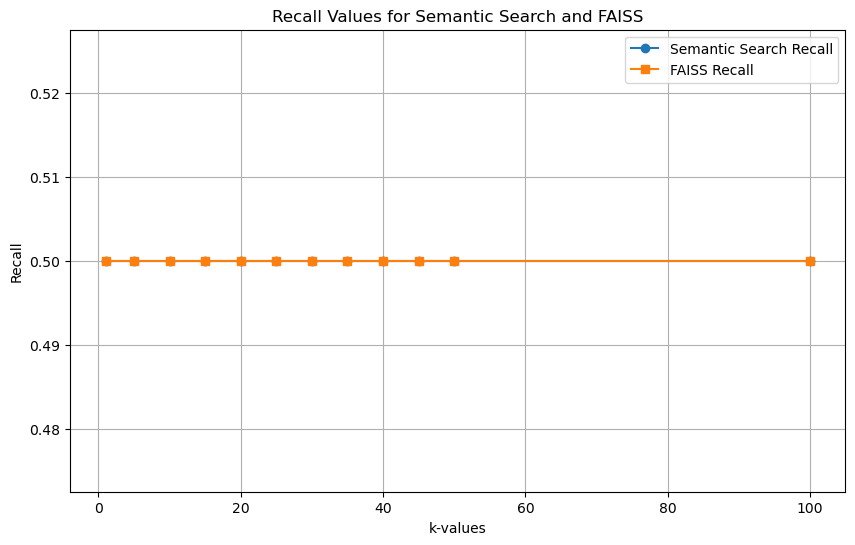

Semantic Search Results:
Query                                    | Semantic Result     
-----------------------------------------------------------------
How could a white child be considered a member of the Omaha tribe? | The social identity of the children was strongly determined by the tribe's kinship system. Among the matrilineal tribes of the Southeast, the mixed-race children generally were accepted as and identified as Indian, as they gained their social status from their mother's clans and tribes, and often grew up with their mothers and their male relatives. By contrast, among the patrilineal Omaha, for example, the child of a white man and Omaha woman was considered "white"; such mixed-race children and their mothers would be protected, but the children could formally belong to the tribe as members only if adopted by a man.
How could a white child be considered a member of the Omaha tribe? | The social identity of the children was strongly determined by the tribe's kinship s

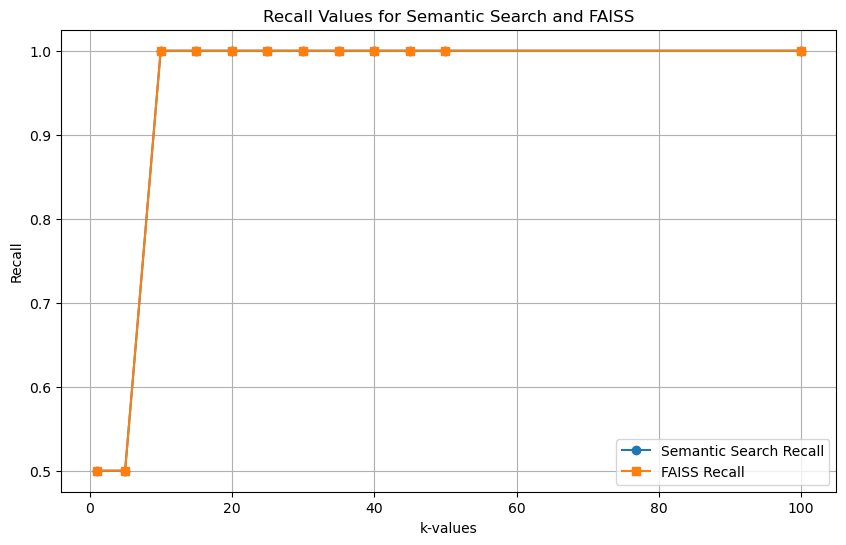

Semantic Search Results:
Query                                    | Semantic Result     
-----------------------------------------------------------------
What was the per capita income for the city? | The median income for a household in the city was $26,969, and the median income for a family was $31,997. Males had a median income of $25,471 versus $23,863 for females. The per capita income for the city was $15,402. About 19.1% of families and 23.6% of the population were below the poverty line, including 29.1% of those under age 18 and 18.9% of those age 65 or over.
What was the per capita income for the city? | The median income for a household in the city was $26,969, and the median income for a family was $31,997. Males had a median income of $25,471 versus $23,863 for females. The per capita income for the city was $15,402. About 19.1% of families and 23.6% of the population were below the poverty line, including 29.1% of those under age 18 and 18.9% of those age 65 or over.
Wha

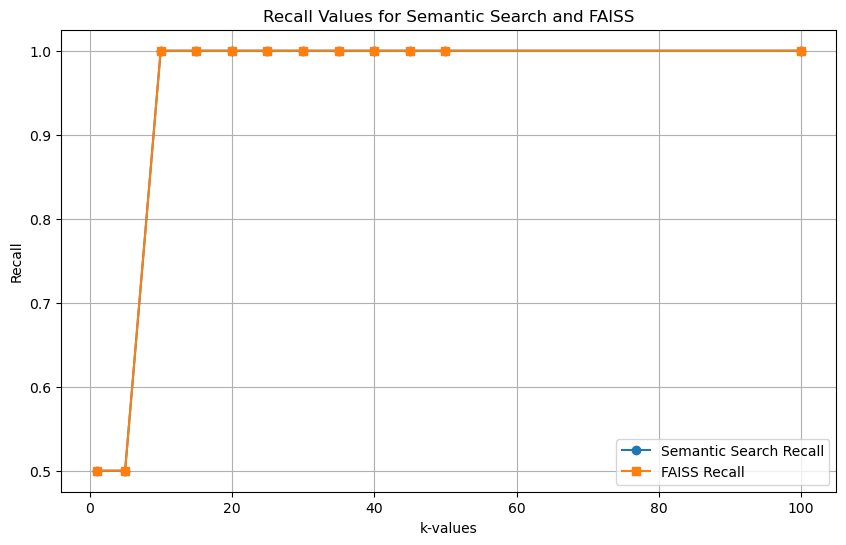

Semantic Search Results:
Query                                    | Semantic Result     
-----------------------------------------------------------------
What does DRM stand for?                 | The ReWritable Audio CD is designed to be used in a consumer audio CD recorder, which will not (without modification) accept standard CD-RW discs. These consumer audio CD recorders use the Serial Copy Management System (SCMS), an early form of digital rights management (DRM), to conform to the United States' Audio Home Recording Act (AHRA). The ReWritable Audio CD is typically somewhat more expensive than CD-RW due to (a) lower volume and (b) a 3% AHRA royalty used to compensate the music industry for the making of a copy.
What does DRM stand for?                 | The ReWritable Audio CD is designed to be used in a consumer audio CD recorder, which will not (without modification) accept standard CD-RW discs. These consumer audio CD recorders use the Serial Copy Management System (SCMS), an 

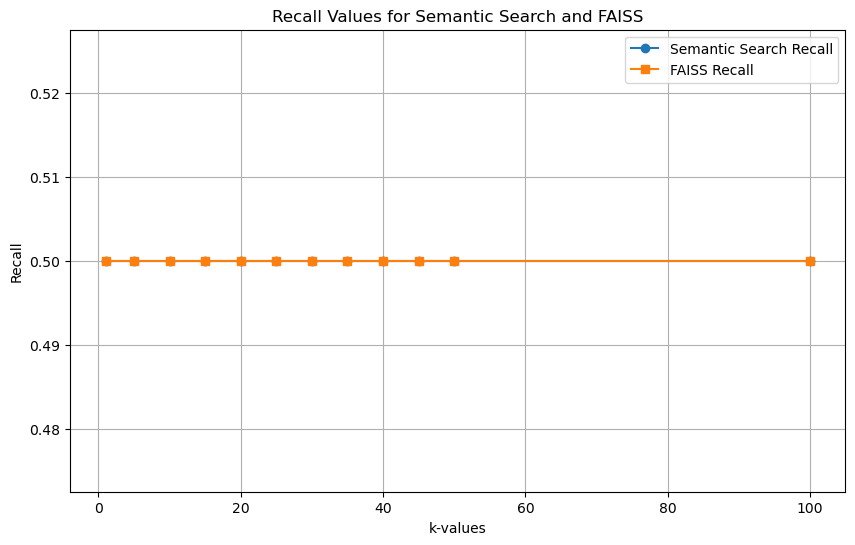

Semantic Search Results:
Query                                    | Semantic Result     
-----------------------------------------------------------------
Who wrote the Divine Comedy?             | Dante Alighieri's Divine Comedy, written in the early 14th century, merged a medieval world view with classical ideals. Another promoter of the Italian language was Boccaccio with his Decameron. The application of the vernacular did not entail a rejection of Latin, and both Dante and Boccaccio wrote prolifically in Latin as well as Italian, as would Petrarch later (whose Canzoniere also promoted the vernacular and whose contents are considered the first modern lyric poems). Together the three poets established the Tuscan dialect as the norm for the modern Italian language.
Who wrote the Divine Comedy?             | Dante Alighieri's Divine Comedy, written in the early 14th century, merged a medieval world view with classical ideals. Another promoter of the Italian language was Boccaccio with

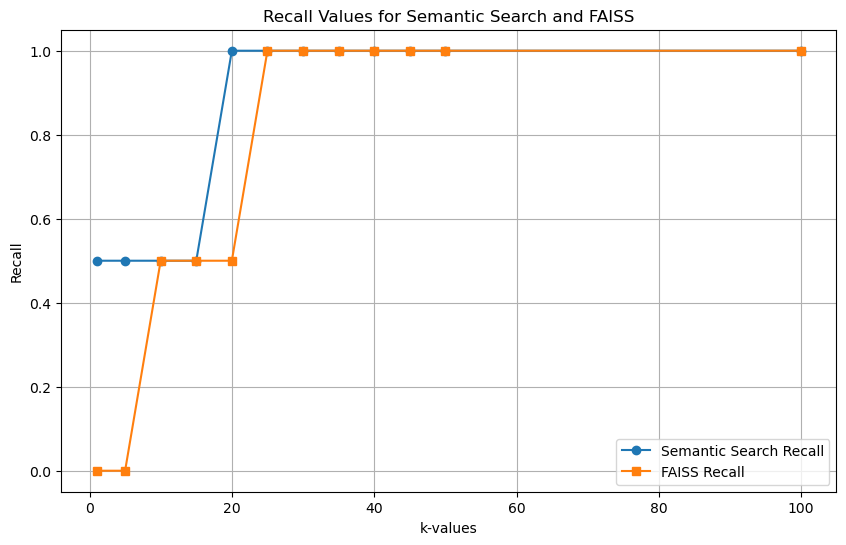

Semantic Search Results:
Query                                    | Semantic Result     
-----------------------------------------------------------------
In what year did Chopin become a French citizen? | Chopin arrived in Paris in late September 1831; he would never return to Poland, thus becoming one of many expatriates of the Polish Great Emigration. In France he used the French versions of his given names, and after receiving French citizenship in 1835, he travelled on a French passport. However, Chopin remained close to his fellow Poles in exile as friends and confidants and he never felt fully comfortable speaking French. Chopin's biographer Adam Zamoyski writes that he never considered himself to be French, despite his father's French origins, and always saw himself as a Pole.
In what year did Chopin become a French citizen? | Chopin arrived in Paris in late September 1831; he would never return to Poland, thus becoming one of many expatriates of the Polish Great Emigration. In

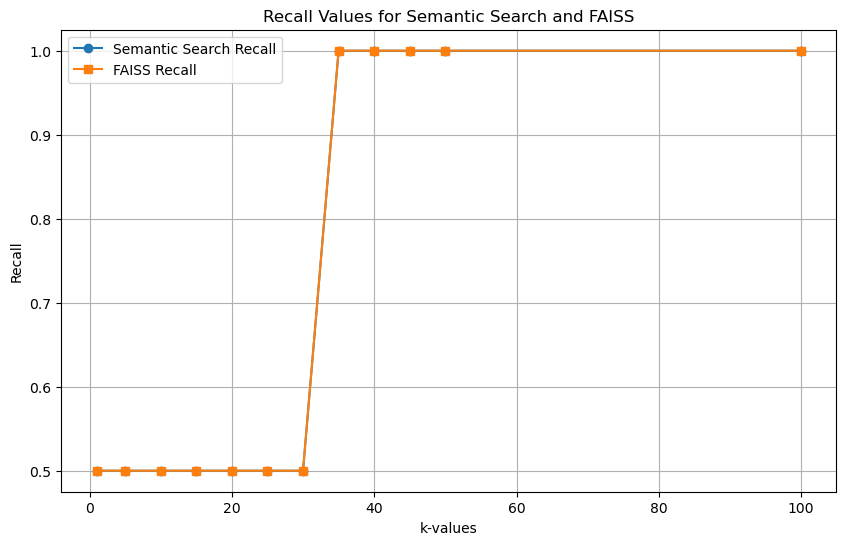

In [118]:
k_values = [1,5,10,15, 20, 25, 30, 35, 40, 45, 50, 100]
for query in queries:
    calculate_and_visualize_recall(query, k_values, model, True)

### Uśrednienie wszystkich pytań

In [119]:
def plot_average_recall(results_for_query):

    data = []

    for query, results in results_for_query.items():
        for k, values in results.items():
            data.append({"Query": query, "k": k, "Recall_Semantic": values[0], "Recall_FAISS": values[1]})

    df = pd.DataFrame(data)

    average_results = df.groupby("k")[["Recall_Semantic", "Recall_FAISS"]].mean()

    plt.figure(figsize=(10, 6))
    plt.plot(average_results.index, average_results["Recall_Semantic"], label="Recall Semantic", marker="o")
    plt.plot(average_results.index, average_results["Recall_FAISS"], label="Recall FAISS", marker="o")

    plt.title("Average Recall for Semantic and FAISS by k")
    plt.xlabel("k")
    plt.ylabel("Average Recall")
    plt.legend()
    plt.grid(True)
    plt.show()

In [120]:
all_question = list(duplicated_question_unique_answer.keys())
len((all_question))

66

In [121]:
k_values = [1, 5, 10, 15, 20, 25, 50, 100, 200]
results_for_query = {}

for query in all_question:
    results = calculate_and_visualize_recall(query, k_values, model, False)
    results_for_query[query] = results

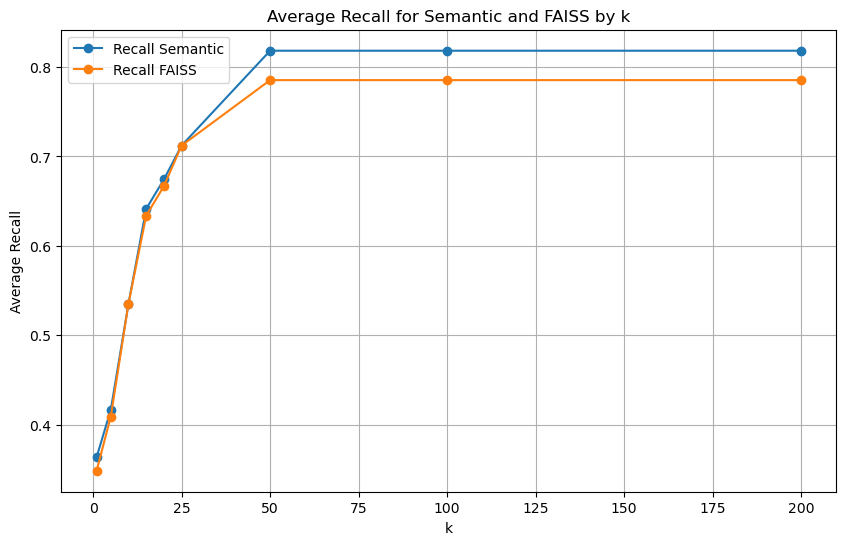

In [122]:
plot_average_recall(results_for_query)

## MRR

In [123]:
def get_correct_positions(correct, predicted):

    positions = []
    for idx, item in enumerate(predicted):
        if item in correct:
            positions.append(idx)
    return positions

def get_correct_positions_without_duplicates(correct, predicted):

    unique_predicted = []
    for item in predicted:
        if item not in unique_predicted:
            unique_predicted.append(item)

    positions = []
    for idx, item in enumerate(unique_predicted):
        if item in correct:
            positions.append(idx+1)
    return positions

def get_answers( query, model, top_k=200, answer_embeddings = answer_embeddings_np, answer_texts=answers, hf_dataset= hf_dataset, correct_answers_dict=complete_dict, is_faiss_automatic = True):
    query_embedding = model.encode([query], convert_to_tensor=True)
    cosine_scores = cosine_similarity(query_embedding.cpu().numpy(), answer_embeddings)
    top_k_indices = np.argsort(cosine_scores[0])[-top_k:][::-1]
    
    semantic_search = [answer_texts[i] for i in top_k_indices]

    if is_faiss_automatic:
        scores, examples = hf_dataset.get_nearest_examples(
            index_name="answer_embedding", 
            query=query_embedding.cpu().numpy(),  
            k=top_k
        )
        
        faiss_search = examples['answer']
    else:
        faiss_search = faiss_search_manual(query, answer_embeddings, answer_texts, model, top_k)
    
    correct_answers = complete_dict[query]

    return semantic_search, faiss_search, correct_answers, 


def calculate_MRR(actual_relevant):
    Q = len(actual_relevant)
    cumulative_reciprocal = 0
    for i in range(Q):
        if(len(actual_relevant[i]) == 0):
            reciprocal = 0
        else:
            first_result = actual_relevant[i][0]
            reciprocal = 1 / first_result
        cumulative_reciprocal += reciprocal
        print(f"query #{i+1} = 1/{first_result} = {reciprocal}")

    mrr = 1/Q * cumulative_reciprocal

    print("MRR =", round(mrr,2))

    return mrr

In [124]:
random.seed(42)
queries = random.sample(list(complete_dict.keys()), 500)

In [125]:
actual_relevant_semantic = []
actual_relevant_faiss = []

for query in queries:
    semantic_search, faiss_search, correct_answers = get_answers(query, model)
    single_query_result_semantic = get_correct_positions_without_duplicates(correct_answers, semantic_search )
    single_query_result_faiss = get_correct_positions_without_duplicates(correct_answers, faiss_search )
    actual_relevant_semantic.append(single_query_result_semantic)
    actual_relevant_faiss.append(single_query_result_faiss)

query #1 = 1/2 = 0.5
query #2 = 1/1 = 1.0
query #3 = 1/1 = 1.0
query #4 = 1/2 = 0.5
query #5 = 1/5 = 0.2
query #6 = 1/1 = 1.0
query #7 = 1/1 = 1.0
query #8 = 1/1 = 1.0
query #9 = 1/1 = 1.0
query #10 = 1/1 = 1.0
query #11 = 1/1 = 1.0
query #12 = 1/1 = 1.0
query #13 = 1/14 = 0.07142857142857142
query #14 = 1/1 = 1.0
query #15 = 1/1 = 1.0
query #16 = 1/3 = 0.3333333333333333
query #17 = 1/1 = 1.0
query #18 = 1/1 = 1.0
query #19 = 1/1 = 1.0
query #20 = 1/16 = 0.0625
query #21 = 1/1 = 1.0
query #22 = 1/3 = 0.3333333333333333
query #23 = 1/2 = 0.5
query #24 = 1/1 = 1.0
query #25 = 1/1 = 1.0
query #26 = 1/1 = 1.0
query #27 = 1/1 = 1.0
query #28 = 1/1 = 1.0
query #29 = 1/1 = 1.0
query #30 = 1/1 = 1.0
query #31 = 1/3 = 0.3333333333333333
query #32 = 1/1 = 1.0
query #33 = 1/3 = 0.3333333333333333
query #34 = 1/3 = 0.3333333333333333
query #35 = 1/2 = 0.5
query #36 = 1/2 = 0.5
query #37 = 1/1 = 1.0
query #38 = 1/2 = 0.5
query #39 = 1/1 = 1.0
query #40 = 1/2 = 0.5
query #41 = 1/2 = 0.5
query #42 =

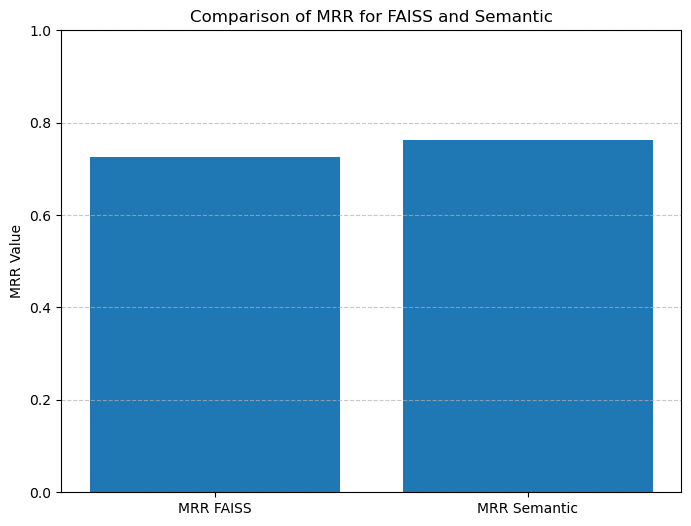

In [126]:
mrr_faiss = calculate_MRR(actual_relevant_faiss)
mrr_semantic = calculate_MRR(actual_relevant_semantic)


labels = ['MRR FAISS', 'MRR Semantic']
values = [mrr_faiss, mrr_semantic]

plt.figure(figsize=(8, 6))
plt.bar(labels, values)
plt.ylim(0, 1)  
plt.ylabel('MRR Value')
plt.title('Comparison of MRR for FAISS and Semantic')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# MANUAL FAISS

In [127]:
k_values = [1, 5, 10, 15, 20, 25, 50, 100, 200]
results_for_query = {}

for query in all_question:
    results = calculate_and_visualize_recall(query, k_values, model, False, is_faiss_automatic=False)
    results_for_query[query] = results

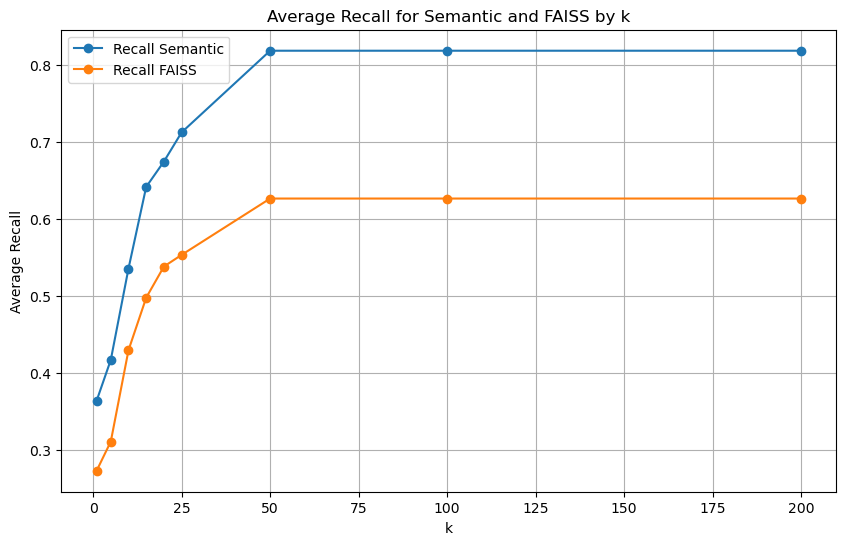

In [128]:
plot_average_recall(results_for_query)

In [129]:
actual_relevant_semantic = []
actual_relevant_faiss = []

for query in queries:
    semantic_search, faiss_search, correct_answers = get_answers(query, model, is_faiss_automatic=False)
    single_query_result_semantic = get_correct_positions_without_duplicates(correct_answers, semantic_search )
    single_query_result_faiss = get_correct_positions_without_duplicates(correct_answers, faiss_search )
    actual_relevant_semantic.append(single_query_result_semantic)
    actual_relevant_faiss.append(single_query_result_faiss)

query #1 = 1/2 = 0.5
query #2 = 1/1 = 1.0
query #3 = 1/1 = 1.0
query #4 = 1/2 = 0.5
query #5 = 1/2 = 0
query #6 = 1/1 = 1.0
query #7 = 1/1 = 1.0
query #8 = 1/1 = 1.0
query #9 = 1/1 = 1.0
query #10 = 1/1 = 0
query #11 = 1/1 = 0
query #12 = 1/1 = 1.0
query #13 = 1/9 = 0.1111111111111111
query #14 = 1/1 = 1.0
query #15 = 1/1 = 0
query #16 = 1/1 = 0
query #17 = 1/1 = 1.0
query #18 = 1/1 = 1.0
query #19 = 1/1 = 1.0
query #20 = 1/11 = 0.09090909090909091
query #21 = 1/11 = 0
query #22 = 1/2 = 0.5
query #23 = 1/2 = 0
query #24 = 1/1 = 1.0
query #25 = 1/1 = 1.0
query #26 = 1/1 = 0
query #27 = 1/1 = 1.0
query #28 = 1/1 = 1.0
query #29 = 1/1 = 1.0
query #30 = 1/1 = 1.0
query #31 = 1/3 = 0.3333333333333333
query #32 = 1/1 = 1.0
query #33 = 1/2 = 0.5
query #34 = 1/2 = 0
query #35 = 1/2 = 0.5
query #36 = 1/1 = 1.0
query #37 = 1/1 = 1.0
query #38 = 1/1 = 1.0
query #39 = 1/1 = 0
query #40 = 1/2 = 0.5
query #41 = 1/1 = 1.0
query #42 = 1/1 = 1.0
query #43 = 1/1 = 1.0
query #44 = 1/1 = 0
query #45 = 1/2

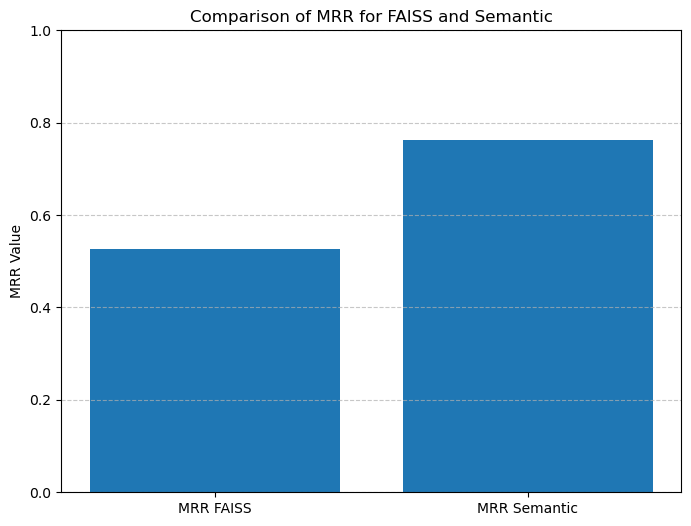

In [130]:
mrr_faiss = calculate_MRR(actual_relevant_faiss)
mrr_semantic = calculate_MRR(actual_relevant_semantic)


labels = ['MRR FAISS', 'MRR Semantic']
values = [mrr_faiss, mrr_semantic]

plt.figure(figsize=(8, 6))
plt.bar(labels, values)
plt.ylim(0, 1)  
plt.ylabel('MRR Value')
plt.title('Comparison of MRR for FAISS and Semantic')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# Różnica czasu

In [132]:
import time

def measure_search_times(questions, model, top_k=5, answer_embeddings=answer_embeddings_np, answer_texts=answers, hf_dataset=hf_dataset, is_faiss_automatic=True):
    times = []

    for query in questions:
        query_embedding = model.encode([query], convert_to_tensor=True)

        # Semantic search timing
        start_semantic = time.time()
        cosine_scores = cosine_similarity(query_embedding.cpu().numpy(), answer_embeddings)
        top_k_indices = np.argsort(cosine_scores[0])[-top_k:][::-1]
        semantic_search = [answer_texts[i] for i in top_k_indices]
        time_semantic = time.time() - start_semantic

        # FAISS search timing
        start_faiss = time.time()
        if is_faiss_automatic:  # Automatic FAISS search
            scores, examples = hf_dataset.get_nearest_examples(
                index_name="answer_embedding", 
                query=query_embedding.cpu().numpy(),  
                k=top_k
            )
            faiss_search = examples['answer']
        else:
            faiss_search = faiss_search_manual(query, answer_embeddings, answer_texts, model, top_k)
        time_faiss = time.time() - start_faiss

        # Append results
        times.append({"query": query, "time_semantic": time_semantic, "time_faiss": time_faiss})

    return times


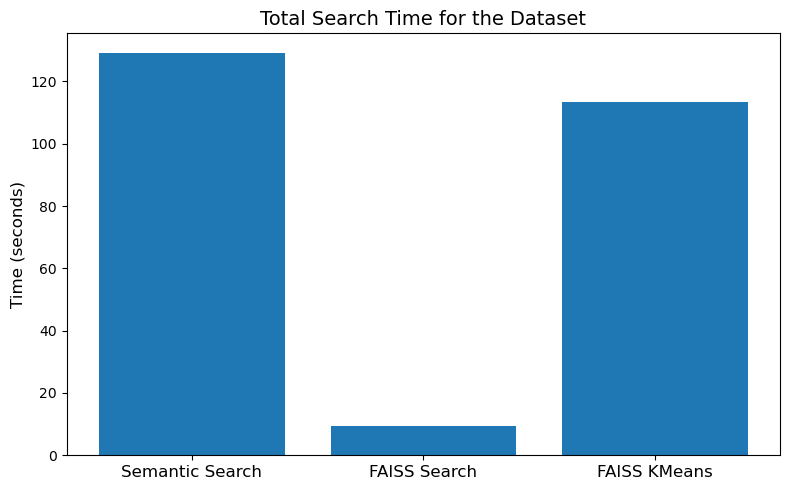

In [133]:
result = measure_search_times(queries, model)
result_kmeans =  measure_search_times(queries, model, is_faiss_automatic=False)

semantic_times = [r["time_semantic"] for r in result]
faiss_times = [r["time_faiss"] for r in result]
kmeans_times = [r["time_faiss"] for r in result_kmeans]


total_semantic_time = sum(semantic_times)
total_faiss_time = sum(faiss_times)
total_kmeans = sum(kmeans_times)

methods = ['Semantic Search', 'FAISS Search', 'FAISS KMeans']
total_times = [total_semantic_time, total_faiss_time, total_kmeans]

plt.figure(figsize=(8, 5))
plt.bar(methods, total_times)


plt.title("Total Search Time for the Dataset", fontsize=14)
plt.ylabel("Time (seconds)", fontsize=12)
plt.xticks(fontsize=12)

# Wyświetlenie wykresu
plt.tight_layout()
plt.show()


# Reranker

In [1]:
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset
import numpy as np
from datasets import Dataset
import pandas as pd
import re
import matplotlib.pyplot as plt

from prettytable import PrettyTable
from sklearn.metrics.pairwise import cosine_similarity
import random
import faiss
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [2]:
model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')

In [3]:
reranker_model = AutoModelForSequenceClassification.from_pretrained("cross-encoder/ms-marco-MiniLM-L-6-v2")
reranker_tokenizer = AutoTokenizer.from_pretrained("cross-encoder/ms-marco-MiniLM-L-6-v2")

reranker_model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-1

# Dane - liczenie od nowa

In [ ]:
dataset = load_dataset("sentence-transformers/squad")
questions = dataset['train']['question']
answers = dataset['train']['answer']

question_embeddings = model.encode(questions, convert_to_tensor=True, show_progress_bar=True)
answer_embeddings = model.encode(answers, convert_to_tensor=True, show_progress_bar=True)

question_embeddings_np = question_embeddings.cpu().numpy()
answer_embeddings_np = answer_embeddings.cpu().numpy()
data = {
    "question": questions,
    "answer": answers,
    "question_embedding": list(question_embeddings_np),
    "answer_embedding": list(answer_embeddings_np)
}

df = pd.DataFrame(data)


df_dataset = Dataset.from_pandas(df)
df_dataset = df_dataset.add_faiss_index(column="answer_embedding")

questions = df['question'].to_list()
answers = df['answer'].to_list()
question_embeddings_np = list(question_embeddings_np)
answer_embeddings_np = list(answer_embeddings_np)


# Dane z csv

In [4]:
def fix_and_convert_to_array(embedding_str):
   
    fixed_str = re.sub(r'(\d)(\s)(-?\d)', r'\1,\3', embedding_str.strip())
    fixed_str = fixed_str.replace('[', '').replace(']', '')  
    fixed_list = list(map(float, fixed_str.split(',')))  
    return np.array(fixed_list) 


df = pd.read_csv('embeddings_zad3.csv')

df['question_embedding'] = df['question_embedding'].apply(fix_and_convert_to_array)
df['answer_embedding'] = df['answer_embedding'].apply(fix_and_convert_to_array)



df_dataset = Dataset.from_pandas(df)
df_dataset = df_dataset.add_faiss_index(column="answer_embedding")

questions = df['question'].to_list()
answers = df['answer'].to_list()
question_embeddings_np = np.vstack(df['question_embedding'].to_numpy())
answer_embeddings_np = np.vstack(df['answer_embedding'].to_numpy())

  0%|          | 0/88 [00:00<?, ?it/s]

# Funkcje do  wyszukiwania

In [40]:
def fun_semantic_search(query, model=model, answer_embedding=answer_embeddings_np, answer_texts=answers, top_k=200):
    query_embedding = model.encode([query], convert_to_tensor=True)
    cosine_scores = cosine_similarity(
        query_embedding.cpu().numpy(), answer_embedding
    )
    top_k_indices = np.argsort(cosine_scores[0])[-top_k:][::-1]
    return [answer_texts[i] for i in top_k_indices]

In [6]:
def faiss_search_with_df(query, hf_dataset=df_dataset, model=model, top_k=200):

    query_embedding = model.encode(query, convert_to_tensor=True).cpu().numpy()
    
    scores, examples = hf_dataset.get_nearest_examples(
        index_name="answer_embedding", 
        query=query_embedding,  # Single query embedding
        k=top_k
    )
    
    return list(examples["answer"])

In [7]:
def search_with_reranker(model, tokenizer, query, answers, top_k=3):
    scores = []
    for candidate in answers:
        inputs = tokenizer(query, candidate, return_tensors="pt", truncation=True, padding=True)
    
        with torch.no_grad():
            logits = model(**inputs).logits
            score = logits.item()
            scores.append(score)
    
    ranked_results = sorted(zip(answers, scores), key=lambda x: x[1], reverse=True)
    
    top_results = ranked_results[:top_k]

    return [result[0] for result in top_results]

# metryki

In [8]:
def calculate_recall(actual, predicted, k):

    if isinstance(actual, str):
        actual = [actual]

    act_set = set(actual)
    pred_set = set(predicted[:k])

    result = round(len(act_set & pred_set) / float(len(act_set)), 2)
    return result

In [9]:
def get_correct_positions_without_duplicates(correct, predicted):

    unique_predicted = []
    for item in predicted:
        if item not in unique_predicted:
            unique_predicted.append(item)

    positions = []
    for idx, item in enumerate(unique_predicted):
        if item in correct:
            positions.append(idx+1)
    return positions

In [25]:
def calculate_MRR(actual_relevant):
    Q = len(actual_relevant)
    cumulative_reciprocal = 0
    for i in range(Q):
        if(len(actual_relevant[i]) == 0):
            reciprocal = 0
            print(f"query #{i+1} = {reciprocal}")
        else:
            first_result = actual_relevant[i][0]
            reciprocal = 1 / first_result
            print(f"query #{i+1} = 1/{first_result} = {reciprocal}")
        cumulative_reciprocal += reciprocal

    mrr = 1/Q * cumulative_reciprocal

    print("MRR =", round(mrr,2))

    return mrr

# dobre odpowiedzi

In [11]:
question_answer_dict = df.drop_duplicates(subset=['question', 'answer']).set_index('question')['answer'].to_dict()
duplicated_questions = df[df.duplicated(subset='question', keep=False)]
duplicated_question_answer_dict = duplicated_questions.groupby('question')['answer'].apply(list).to_dict()
duplicated_question_unique_answer = {
    question: answers for question, answers in duplicated_question_answer_dict.items() if len(answers) == len(set(answers))
}
complete_dict = question_answer_dict | duplicated_question_answer_dict

In [ ]:
# random.seed(42)
# queries = random.sample(list(complete_dict.keys()), 500)

# Odpowiedzi

In [12]:
def generate_tables(query, semantic_results, faiss_results, reranker_results, reranker_faiss_results, correct_answers):
    def format_table(header, rows):
        table = f"{header[0]:<40} | {header[1]:<20}\n"
        table += "-" * 65 + "\n"
        for row in rows:
            table += f"{row[0]:<40} | {row[1]:<20}\n"
        return table

    semantic_rows = [(query, result) for result in semantic_results]
    faiss_rows = [(query, result) for result in faiss_results]
    reranker_rows = [(query, result) for result in reranker_results]
    reranker_faiss_rows = [(query, result) for result in reranker_faiss_results]
    correct_rows = [(query, answer) for answer in correct_answers]

    semantic_table = format_table(["Query", "Semantic Result"], semantic_rows)
    faiss_table = format_table(["Query", "FAISS Result"], faiss_rows)
    reranker_table = format_table(["Query", "Reranker Result"], reranker_rows)
    reranker_faiss_table = format_table(["Query", "Reranker FAISS Result"], reranker_faiss_rows)
    correct_table = format_table(["Query", "Correct Answer"], correct_rows)
    
    print("Semantic Search Results:")
    print(semantic_table)
    print("\nFAISS Search Results:")
    print(faiss_table)
    print("\nReranker Search Results:")
    print(reranker_table)
    print("\nReranker FAISS Search Results:")
    print(reranker_faiss_table)
    print("\nCorrect Answers:")
    print(correct_table)

In [38]:
def pipline(queries, model=model, top_k=30, answer_embeddings=answer_embeddings_np, answer_texts=answers, hf_dataset=df_dataset,
            reranker_model=reranker_model, reranker_tokenizer=reranker_tokenizer, correct_answers_dict=complete_dict, visualize=True):
    
    correct_answers = []
    semantic_results = []
    faiss_results = []
    reranker_results = []
    reranker_faiss_results = []
    
    for query in queries:
        correct_answer = correct_answers_dict[query]
        correct_answers.append(correct_answer)
        
        semantic_result = fun_semantic_search(query, top_k=top_k)
        faiss_result = faiss_search_with_df(query, hf_dataset, model, top_k)
        reranker_result = search_with_reranker(reranker_model, reranker_tokenizer, query, semantic_result, top_k)
        reranker_faiss_result = search_with_reranker(reranker_model, reranker_tokenizer, query, faiss_result, top_k)
        
        semantic_results.append(semantic_result)
        faiss_results.append(faiss_result)
        reranker_results.append(reranker_result)
        reranker_faiss_results.append(reranker_faiss_result)
        
        if visualize:
            generate_tables(query, semantic_result, faiss_result, reranker_result, reranker_faiss_result, correct_answer)
    
    return correct_answers, semantic_results, faiss_results, reranker_results, reranker_faiss_results

In [13]:
random.seed(42)
queries = random.sample(list(duplicated_question_unique_answer.keys()), 6)
queries

['What does CD stand for?',
 'How could a white child be considered a member of the Omaha tribe?',
 'What was the per capita income for the city?',
 'What does DRM stand for?',
 'Who wrote the Divine Comedy?',
 'In what year did Chopin become a French citizen?']

In [15]:
correct_answers, semantic_results, faiss_results, reranker_results, reranker_faiss_results = pipline(queries, top_k=100)

Semantic Search Results:
Query                                    | Semantic Result     
-----------------------------------------------------------------
What does CD stand for?                  | Compact Disc (CD) is a digital optical disc data storage format. The format was originally developed to store and play only sound recordings but was later adapted for storage of data (CD-ROM). Several other formats were further derived from these, including write-once audio and data storage (CD-R), rewritable media (CD-RW), Video Compact Disc (VCD), Super Video Compact Disc (SVCD), Photo CD, PictureCD, CD-i, and Enhanced Music CD. Audio CDs and audio CD players have been commercially available since October 1982.
What does CD stand for?                  | Compact Disc (CD) is a digital optical disc data storage format. The format was originally developed to store and play only sound recordings but was later adapted for storage of data (CD-ROM). Several other formats were further derived from

# Recall

In [16]:
def calculate_recall(actual, predicted, k):

    if isinstance(actual, str):
        actual = [actual]

    act_set = set(actual)
    pred_set = set(predicted[:k])

    result = round(len(act_set & pred_set) / float(len(act_set)), 2)
    return result

In [17]:
def calculate_metric(metric, semantic_search, faiss_search, reranker_search, reranker_faiss_search, correct_answers, k):
    if metric == 'recall':
        recall_semantic = calculate_recall( correct_answers, semantic_search, k)

        recall_faiss = calculate_recall(correct_answers, faiss_search, k)
        
        recall_reranker = calculate_recall(correct_answers, reranker_search, k)
        
        recall_reranker_faiss = calculate_recall(correct_answers, reranker_faiss_search, k)

        return [recall_semantic, recall_faiss, recall_reranker, recall_reranker_faiss]

In [19]:
def calculate_and_visualize_recall(semantic_search, faiss_search, reranker_search, reranker_faiss_search, correct_answers, k_values, idx, visualise=True):
    recall_values_dict = {}

    for k in k_values:
        result = calculate_metric('recall', semantic_search[idx], faiss_search[idx], reranker_search[idx], reranker_faiss_search[idx], correct_answers[idx], k)
        recall_values_dict[k] = result

    semantic_recall = [recall_values_dict[k][0] for k in k_values]
    faiss_recall = [recall_values_dict[k][1] for k in k_values]
    reranker_recall = [recall_values_dict[k][2] for k in k_values]
    reranker_faiss_recall = [recall_values_dict[k][3] for k in k_values]
    
    
    if visualise:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
        
        # Semantic Search vs FAISS
        axes[0].plot(k_values, semantic_recall, marker='o', label='Semantic Search Recall')
        axes[0].plot(k_values, faiss_recall, marker='s', label='FAISS Recall')
        axes[0].set_title('Recall: Semantic Search vs FAISS')
        axes[0].set_xlabel('k-values')
        axes[0].set_ylabel('Recall')
        axes[0].legend()
        axes[0].grid(True)
        
        # Reranker vs Reranker FAISS
        axes[1].plot(k_values, reranker_recall, marker='x', label='Reranker Recall', color='green')
        axes[1].plot(k_values, reranker_faiss_recall, marker='d', label='Reranker FAISS Recall', color='pink')
        axes[1].set_title('Recall: Reranker vs Reranker FAISS')
        axes[1].set_xlabel('k-values')
        axes[1].legend()
        axes[1].grid(True)

        # plt.figure(figsize=(10, 6))
        # plt.plot(k_values, semantic_recall, marker='o', label='Semantic Search Recall')
        # plt.plot(k_values, faiss_recall, marker='s', label='FAISS Recall')
        # plt.plot(k_values, reranker_recall, marker='x', label='Reranker Recall')
        # plt.plot(k_values, reranker_faiss_recall, marker='d', label='Reranker FAISS Recall')

        # plt.title('Recall Values for Semantic Search, FAISS and Reranker')
        # plt.xlabel('k-values')
        # plt.ylabel('Recall')
        # plt.legend()
        # plt.grid(True)
        # plt.show()

    return recall_values_dict

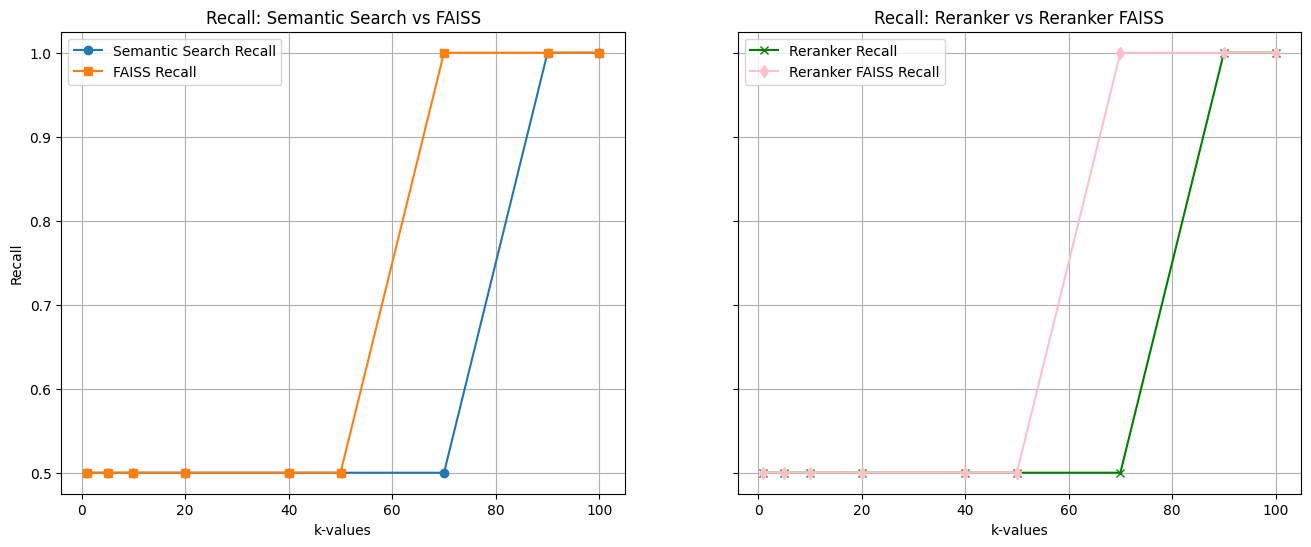

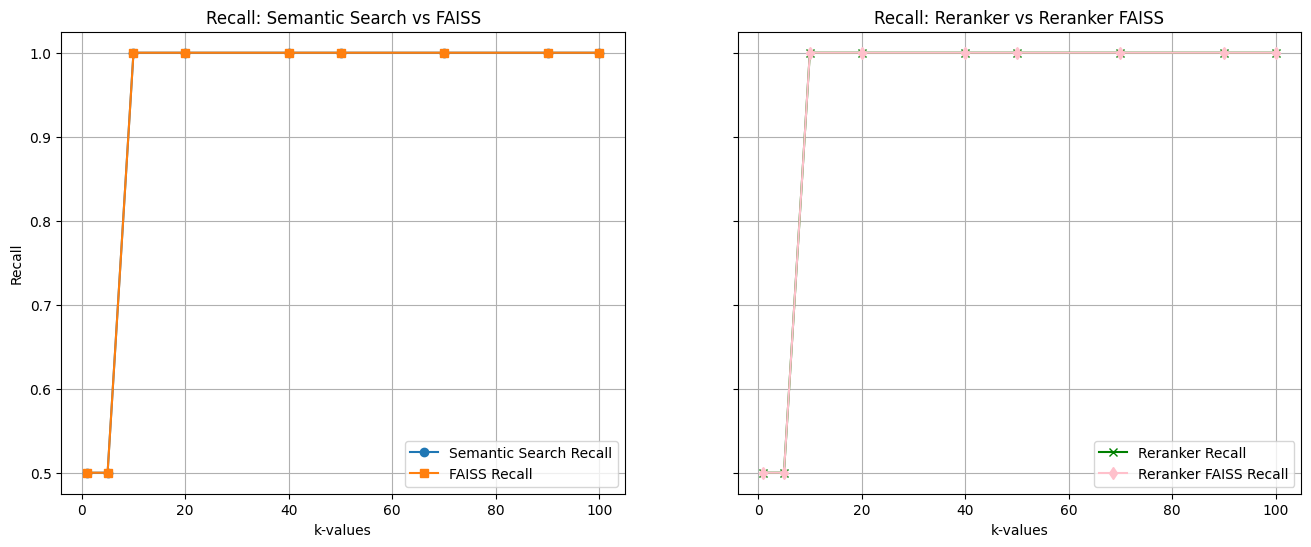

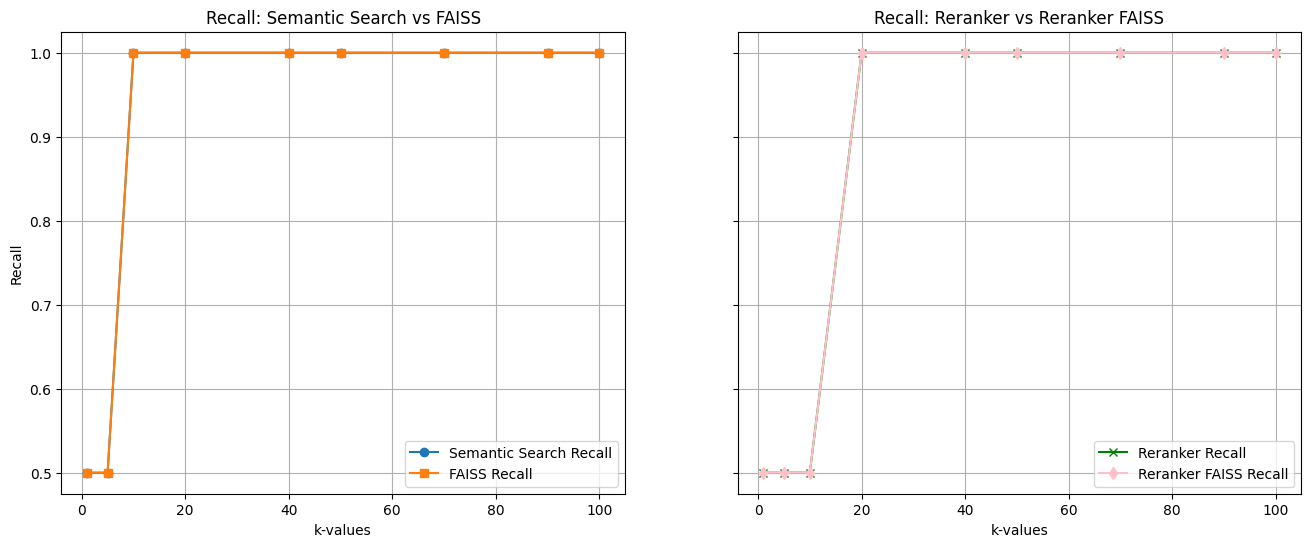

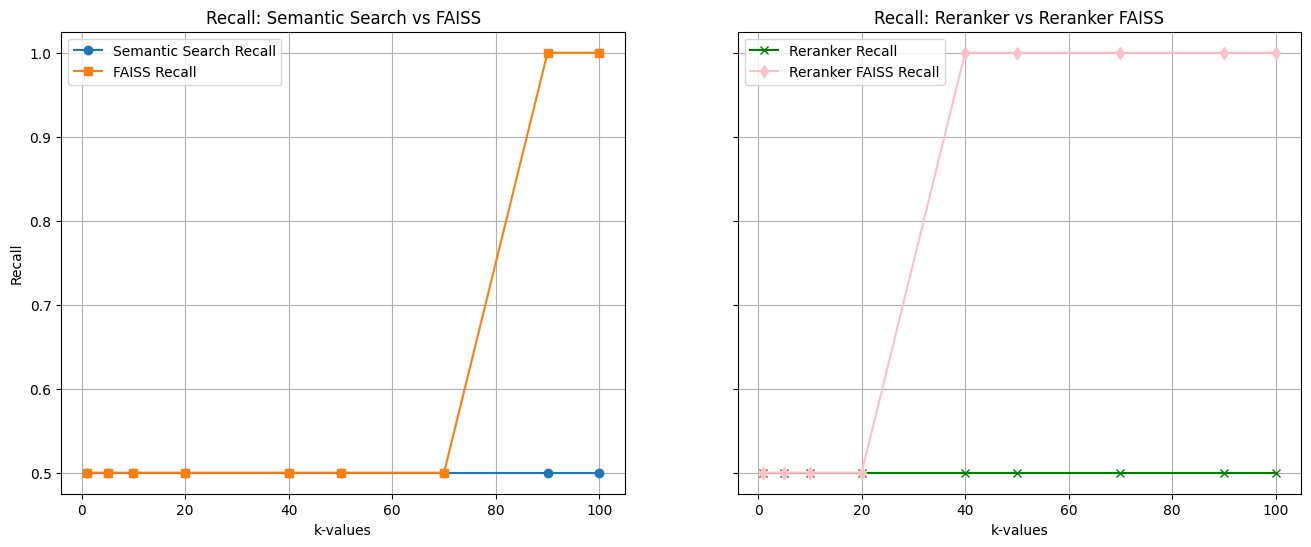

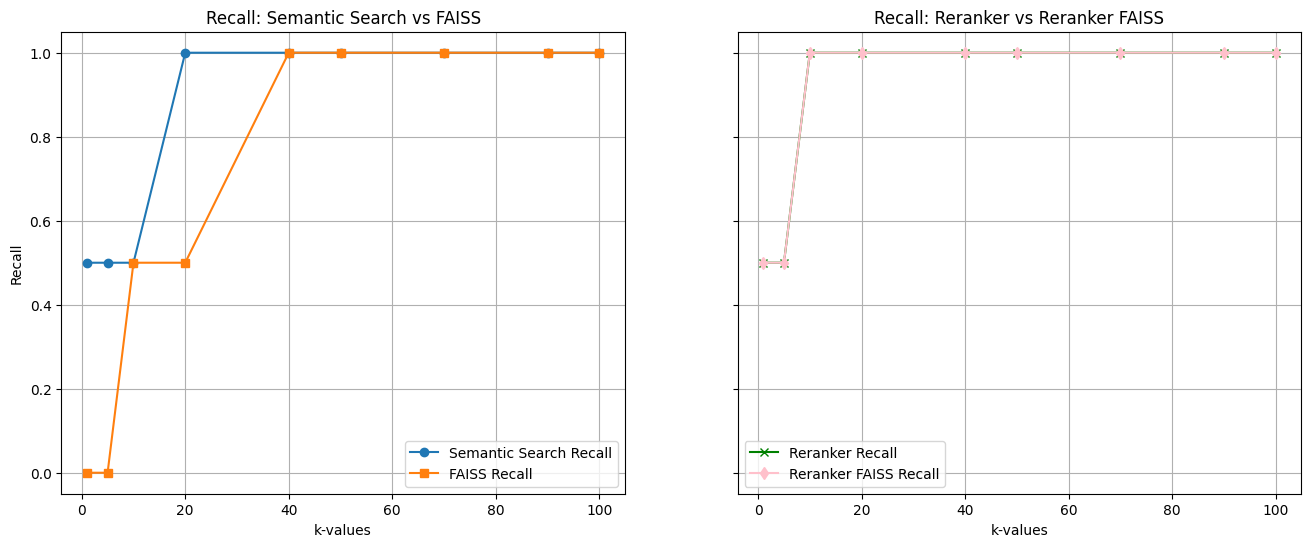

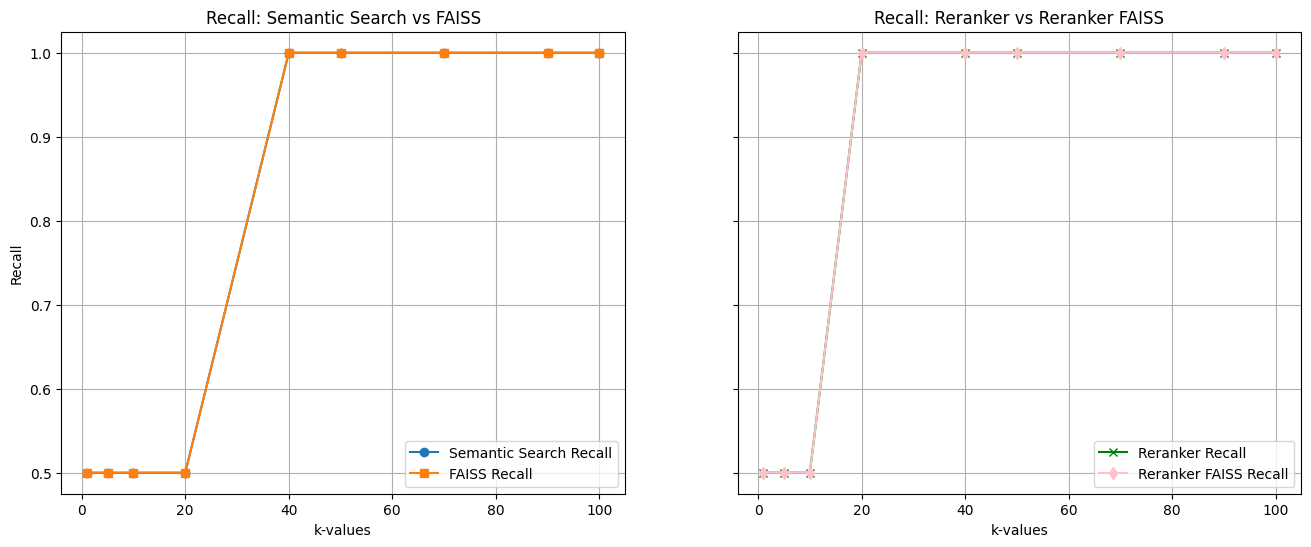

In [21]:
k_values = [1, 5, 10, 20, 40,  50, 70, 90, 100]

for idx, query in enumerate(queries):
    calculate_and_visualize_recall(semantic_results, faiss_results, reranker_results, reranker_faiss_results, correct_answers, k_values, idx)

## Średni recall dla wszystkich pytań

In [53]:
def plot_average_recall(results_for_query):

    data = []

    for query, results in results_for_query.items():
        for k, values in results.items():
            data.append({"Query": query, "k": k, "Recall_Semantic": values[0], "Recall_FAISS": values[1], 'Recall_Reranker': values[2], 'Recall_Reranker_FAISS': values[3]})

    df = pd.DataFrame(data)

    average_results = df.groupby("k")[["Recall_Semantic", "Recall_FAISS", "Recall_Reranker", "Recall_Reranker_FAISS"]].mean()

    plt.figure(figsize=(10, 6))
    plt.plot(average_results.index, average_results["Recall_Semantic"], label="Recall Semantic", marker="o")
    plt.plot(average_results.index, average_results["Recall_FAISS"], label="Recall FAISS", marker="o", alpha=0.9)
    plt.plot(average_results.index, average_results["Recall_Reranker"], label="Recall Reranker", marker="o", alpha=0.7)
    plt.plot(average_results.index, average_results["Recall_Reranker_FAISS"], label="Recall Reranker FAISS", marker="o", alpha=0.5)

    plt.title("Average Recall for Semantic, FAISS, Reranker and Reranker FAISS by k")
    plt.xlabel("k")
    plt.ylabel("Average Recall")
    plt.legend()
    plt.grid(True)
    plt.show()

In [55]:
all_question = list(duplicated_question_unique_answer.keys())
len((all_question))

66

In [56]:
correct_answers_all, semantic_results_all, faiss_results_all, reranker_results_all, reranker_faiss_results_all = pipline(all_question, top_k=100, visualize=False)

In [57]:
results_for_query = {}

for idx, query in enumerate(all_question):
    results = calculate_and_visualize_recall(semantic_results_all, faiss_results_all, reranker_results_all, reranker_faiss_results_all, correct_answers_all, k_values, idx, visualise=False)
    results_for_query[query] = results

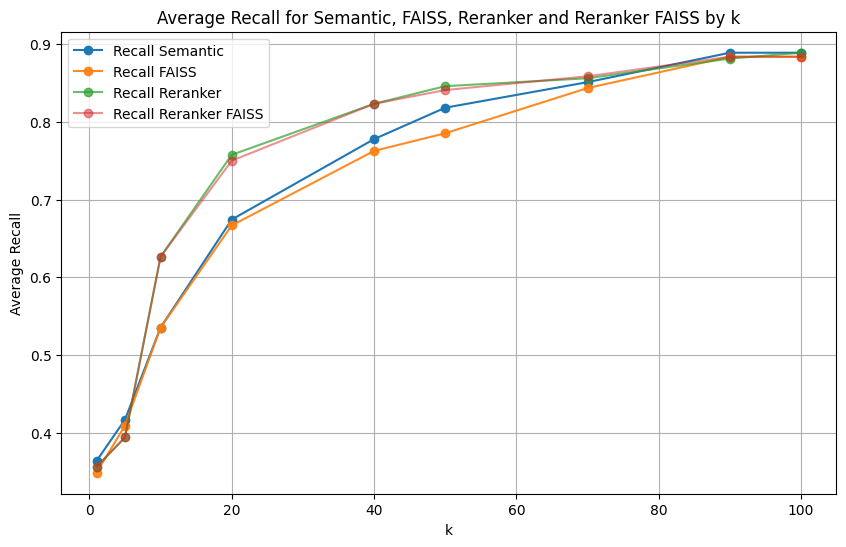

In [58]:
plot_average_recall(results_for_query)

# MRR

In [44]:
random.seed(42)
queries = random.sample(list(complete_dict.keys()), 50)

In [45]:
correct_answers_mrr, semantic_results_mrr, faiss_results_mrr, reranker_results_mrr, reranker_faiss_results_mrr = pipline(queries, top_k=100, visualize=False)

In [46]:
actual_relevant_semantic = []
actual_relevant_faiss = []
actual_relevant_reranker = []
actual_relevant_reranker_faiss = []

for idx, query in enumerate(queries):
    semantic_search, faiss_search, reranker_search, reranker_faiss_search, correct_answers = semantic_results_mrr[idx], faiss_results_mrr[idx], reranker_results_mrr[idx], reranker_faiss_results_mrr[idx], complete_dict[query]
    single_query_result_semantic = get_correct_positions_without_duplicates(correct_answers, semantic_search )
    single_query_result_faiss = get_correct_positions_without_duplicates(correct_answers, faiss_search )
    single_query_result_reranker = get_correct_positions_without_duplicates(correct_answers, reranker_search )
    single_query_result_reranker_faiss = get_correct_positions_without_duplicates(correct_answers, reranker_faiss_search )
    actual_relevant_semantic.append(single_query_result_semantic)
    actual_relevant_faiss.append(single_query_result_faiss)
    actual_relevant_reranker.append(single_query_result_reranker)
    actual_relevant_reranker_faiss.append(single_query_result_reranker_faiss)

In [47]:
mrr_semantic = calculate_MRR(actual_relevant_semantic)
mrr_faiss = calculate_MRR(actual_relevant_faiss)
mrr_reranker = calculate_MRR(actual_relevant_reranker)
mrr_reranker_faiss = calculate_MRR(actual_relevant_reranker_faiss)

query #1 = 1/1 = 1.0
query #2 = 1/1 = 1.0
query #3 = 1/1 = 1.0
query #4 = 1/1 = 1.0
query #5 = 1/4 = 0.25
query #6 = 1/1 = 1.0
query #7 = 1/1 = 1.0
query #8 = 1/1 = 1.0
query #9 = 1/1 = 1.0
query #10 = 1/1 = 1.0
query #11 = 1/1 = 1.0
query #12 = 1/1 = 1.0
query #13 = 1/13 = 0.07692307692307693
query #14 = 1/1 = 1.0
query #15 = 1/1 = 1.0
query #16 = 1/3 = 0.3333333333333333
query #17 = 1/1 = 1.0
query #18 = 1/1 = 1.0
query #19 = 1/1 = 1.0
query #20 = 1/13 = 0.07692307692307693
query #21 = 1/1 = 1.0
query #22 = 1/4 = 0.25
query #23 = 1/2 = 0.5
query #24 = 1/1 = 1.0
query #25 = 1/1 = 1.0
query #26 = 1/1 = 1.0
query #27 = 1/1 = 1.0
query #28 = 1/1 = 1.0
query #29 = 1/1 = 1.0
query #30 = 1/1 = 1.0
query #31 = 1/2 = 0.5
query #32 = 1/1 = 1.0
query #33 = 1/3 = 0.3333333333333333
query #34 = 1/3 = 0.3333333333333333
query #35 = 1/2 = 0.5
query #36 = 1/1 = 1.0
query #37 = 1/1 = 1.0
query #38 = 1/2 = 0.5
query #39 = 1/1 = 1.0
query #40 = 1/2 = 0.5
query #41 = 1/1 = 1.0
query #42 = 1/1 = 1.0
quer

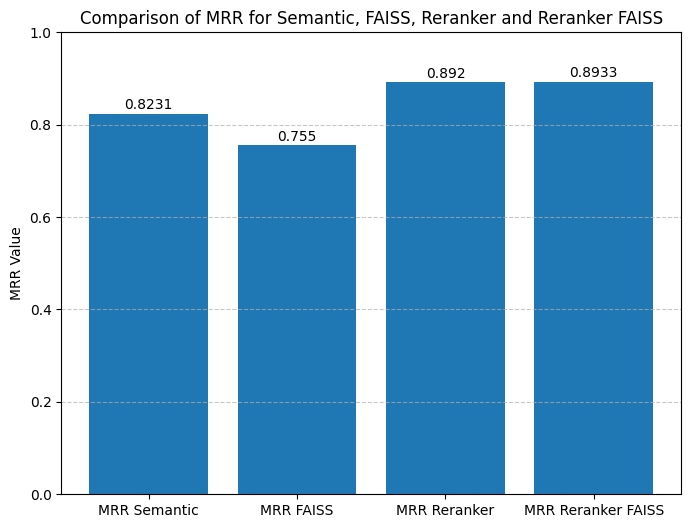

In [52]:
labels = ['MRR Semantic', 'MRR FAISS', 'MRR Reranker', 'MRR Reranker FAISS']
values = [mrr_semantic, mrr_faiss, mrr_reranker, mrr_reranker_faiss]

plt.figure(figsize=(8, 6))
plt.bar(labels, values)
for i, value in enumerate(values):
    plt.text(i, value + 0.01, str(round(value, 4)), ha='center', fontsize=10)

plt.ylim(0, 1)
plt.ylabel('MRR Value')
plt.title('Comparison of MRR for Semantic, FAISS, Reranker and Reranker FAISS')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()